# Multiple well assay with 0.5 uM Abl WT & Src WT and fresh bosutinib, erlotinib, & DMSO. 

## Tested single wv reads at ex 280/em 480, with emission bandwidth 10 & 20 nm. Only going to analyze the bandwidth 20 nm data. 

In [2]:
# %load kinase_single_well_spectra_experiment


# get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from matplotlib.offsetbox import AnchoredText
import matplotlib.cm as cm
import pandas as pd
from lxml import etree
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FormatStrFormatter
import matplotlib
from glob import glob

import assaytools

from assaytools import platereader

ModuleNotFoundError: No module named 'pymc'

In [3]:
concentrations = np.array([  0.00000000e+00,   8.00000000e-09,   1.75e-08,
         3.83e-08,   8.37e-08,   1.83e-07,
         4e-07,   8.75e-07,   1.91e-06,
         4.18e-06,   9.15e-06,   2e-05])

In [4]:
filename = '/Users/caselll1/Desktop/fluorescence_assay/p38_erlotinib_corning_NBS_time_test/2021-04-12_17-49-34_plate_1.xml'

In [5]:
import numpy as np
import re
import string
from lxml import etree

root_node = etree.parse(filename)

In [6]:
section_nodes = { section_node.get('Name') : section_node for section_node in root_node.xpath("/*/Section") }

In [7]:
timestr = 'PT1H30M0.179S'
timestr = 'PT4H0.486S'
timestr = 'PT0S'
matches = re.match('^PT((?P<hours>\d+)H)?((?P<minutes>\d+)M)?((?P<seconds>[\d\.]+)S)?$', timestr)
print(matches)

<re.Match object; span=(0, 4), match='PT0S'>


In [8]:
#=============================================================================================
# Imports
#=============================================================================================


#=============================================================================================
# Tecan Infinite plate reader helper functions
#=============================================================================================

def read_icontrol_kinetic_xml(filename):
    """
    Read a Tecan iControl XML-formatted file kinetic timeseries experiment and return all section data.
    
    Parameters
    ----------
    filename : str
        The name of the XML file to be read.

    Returns
    -------
    data : dict
       data[cycle]['Measurements'][well_label][label_id] is the well reading for well 'well_label' for 0-indexed cycle 'cycle' for LabelId 'label_id' (e.g. data[1]["Wells']['A4'][1] = 954)
       data[cycle]['Time_Start'] is the time (in minutes) of the measurement 'cycle'
       data[cycle]['Temperature'] is the temperature (in Celsius) of the measurement       
       
    Examples
    --------
    
    """
    import numpy as np
    import re
    import string
    from lxml import etree
    
    # Determine number of labels
    # TODO: This is an ugly hack
    matches = re.match('(\d+) Labels', root_node.xpath("/*/Section")[0].get('Name'))
    nlabels = int(matches[1])

    # Populate cycles
    data = dict()
    for cycle_root in root_node.xpath("/*/Section/Data"):
        # Get 1-indexed Cycle id
        cycle = int(cycle_root.get('Cycle')) - 1
        # Initialize cycle
        data[cycle] = dict()
        # Get temperature
        temperature = float(cycle_root.get('Temperature'))
        # Get cycle start time (in minutes since experiment start)
        matches = re.match('^PT((?P<hours>\d+)H)?((?P<minutes>\d+)M)?((?P<seconds>[\d\.]+)S)?$', cycle_root.get('Time_Start'))
        start_time = 0.0
        if matches.group('hours'):
            start_time += float(matches.group('hours')) * 60.
        if matches.group('minutes'):
            start_time += float(matches.group('minutes'))
        if matches.group('seconds'):
            start_time += float(matches.group('seconds')) / 60.    
        data[cycle]['Temperature'] = temperature
        data[cycle]['Time_Start'] = start_time
        # Get well data
        data[cycle]['Measurements'] = dict()   
        for well_root in cycle_root.xpath("Well"):
            well = well_root.get('Pos')
            data[cycle]['Measurements'][well] = dict()
            for measurement_node in well_root.xpath('Single'):
                label_id = measurement_node.get('LabelId')
                measurement = float(measurement_node.text)
                data[cycle]['Measurements'][well][label_id] = measurement
    
    return data

In [9]:
data = read_icontrol_kinetic_xml(filename)

In [10]:
# select LabelId to analyze

label_id = '8' # Ex 280 bw 20 / Em 480 bw 10 / gain 100 / top read
ncycles = len([cycle for cycle in data])

## Extract data for each fluorescence trace over timecourse

In [35]:
systems = { 
    'Erl made 2018-11-29' : ('A', 'B'), 
    'Erl made 2021-04-06' : ('C', 'D'),
    'Erl made 2021-04-12' : ('E', 'F'),
    #'Src:ERL' : ('G', 'H'),
}
nsystems = len(systems)
ncol = 12

plotting_data = dict()

for system in systems:
    complex_row, buffer_row = systems[system]
    plotting_data[system] = dict()
    plotting_data[system]['complex'] = np.zeros([ncycles, ncol], np.float64)
    plotting_data[system]['buffer'] = np.zeros([ncycles, ncol], np.float64)

    complex_wells = [ f'{complex_row}{index+1}' for index in range(12) ]
    buffer_wells = [ f'{buffer_row}{index+1}' for index in range(12) ]

    for cycle in range(ncycles):
        plotting_data[system]['complex'][cycle] = np.array([data[cycle]['Measurements'][well][label_id] for well in complex_wells])
        plotting_data[system]['buffer'][cycle] = np.array([data[cycle]['Measurements'][well][label_id] for well in buffer_wells])

### Let's just plot the first time point

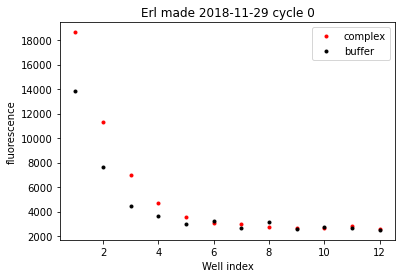

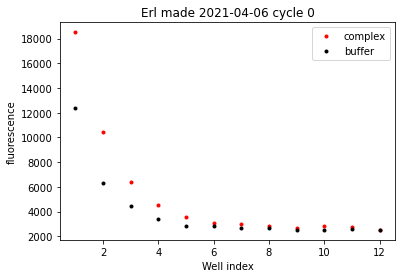

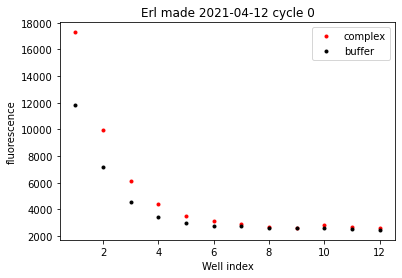

In [36]:
cycle = 0 # plot first time point
for system in systems:
    plt.figure()
    plt.plot(np.arange(1, 13), plotting_data[system]['complex'][cycle], 'r.');
    plt.plot(np.arange(1, 13), plotting_data[system]['buffer'][cycle], 'k.');
    plt.legend(['complex', 'buffer']);
    plt.xlabel('Well index');
    plt.ylabel('fluorescence');
    plt.title(f'{system} cycle {cycle}');

## Create functions for plotting

In [37]:
# plot fluo trace across concentrations with colormap of each timepoint, logx with or without ylim

def fluo_trace_logx(prot, lig, y_prot, y_buff):
    
    for n in range(ncycles):
        x_values = concentrations
        color = cm.rainbow(np.linspace(0,1,20))
        for read, c in zip(y_prot, color):
            plt.semilogx(x_values, np.flip(read), c=c, linestyle='solid')
        for read, c in zip(y_buff, color):
            plt.semilogx(x_values, np.flip(read), c=c, linestyle='dotted')
        
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=16)
        plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=16)
        
        plt.title('%s:%s' % (prot, lig), fontsize =25)
        anchored_text = AnchoredText('Protein = solid \nBuffer = dashed',  loc='upper left', prop=dict(size=16))
        ax1.add_artist(anchored_text)

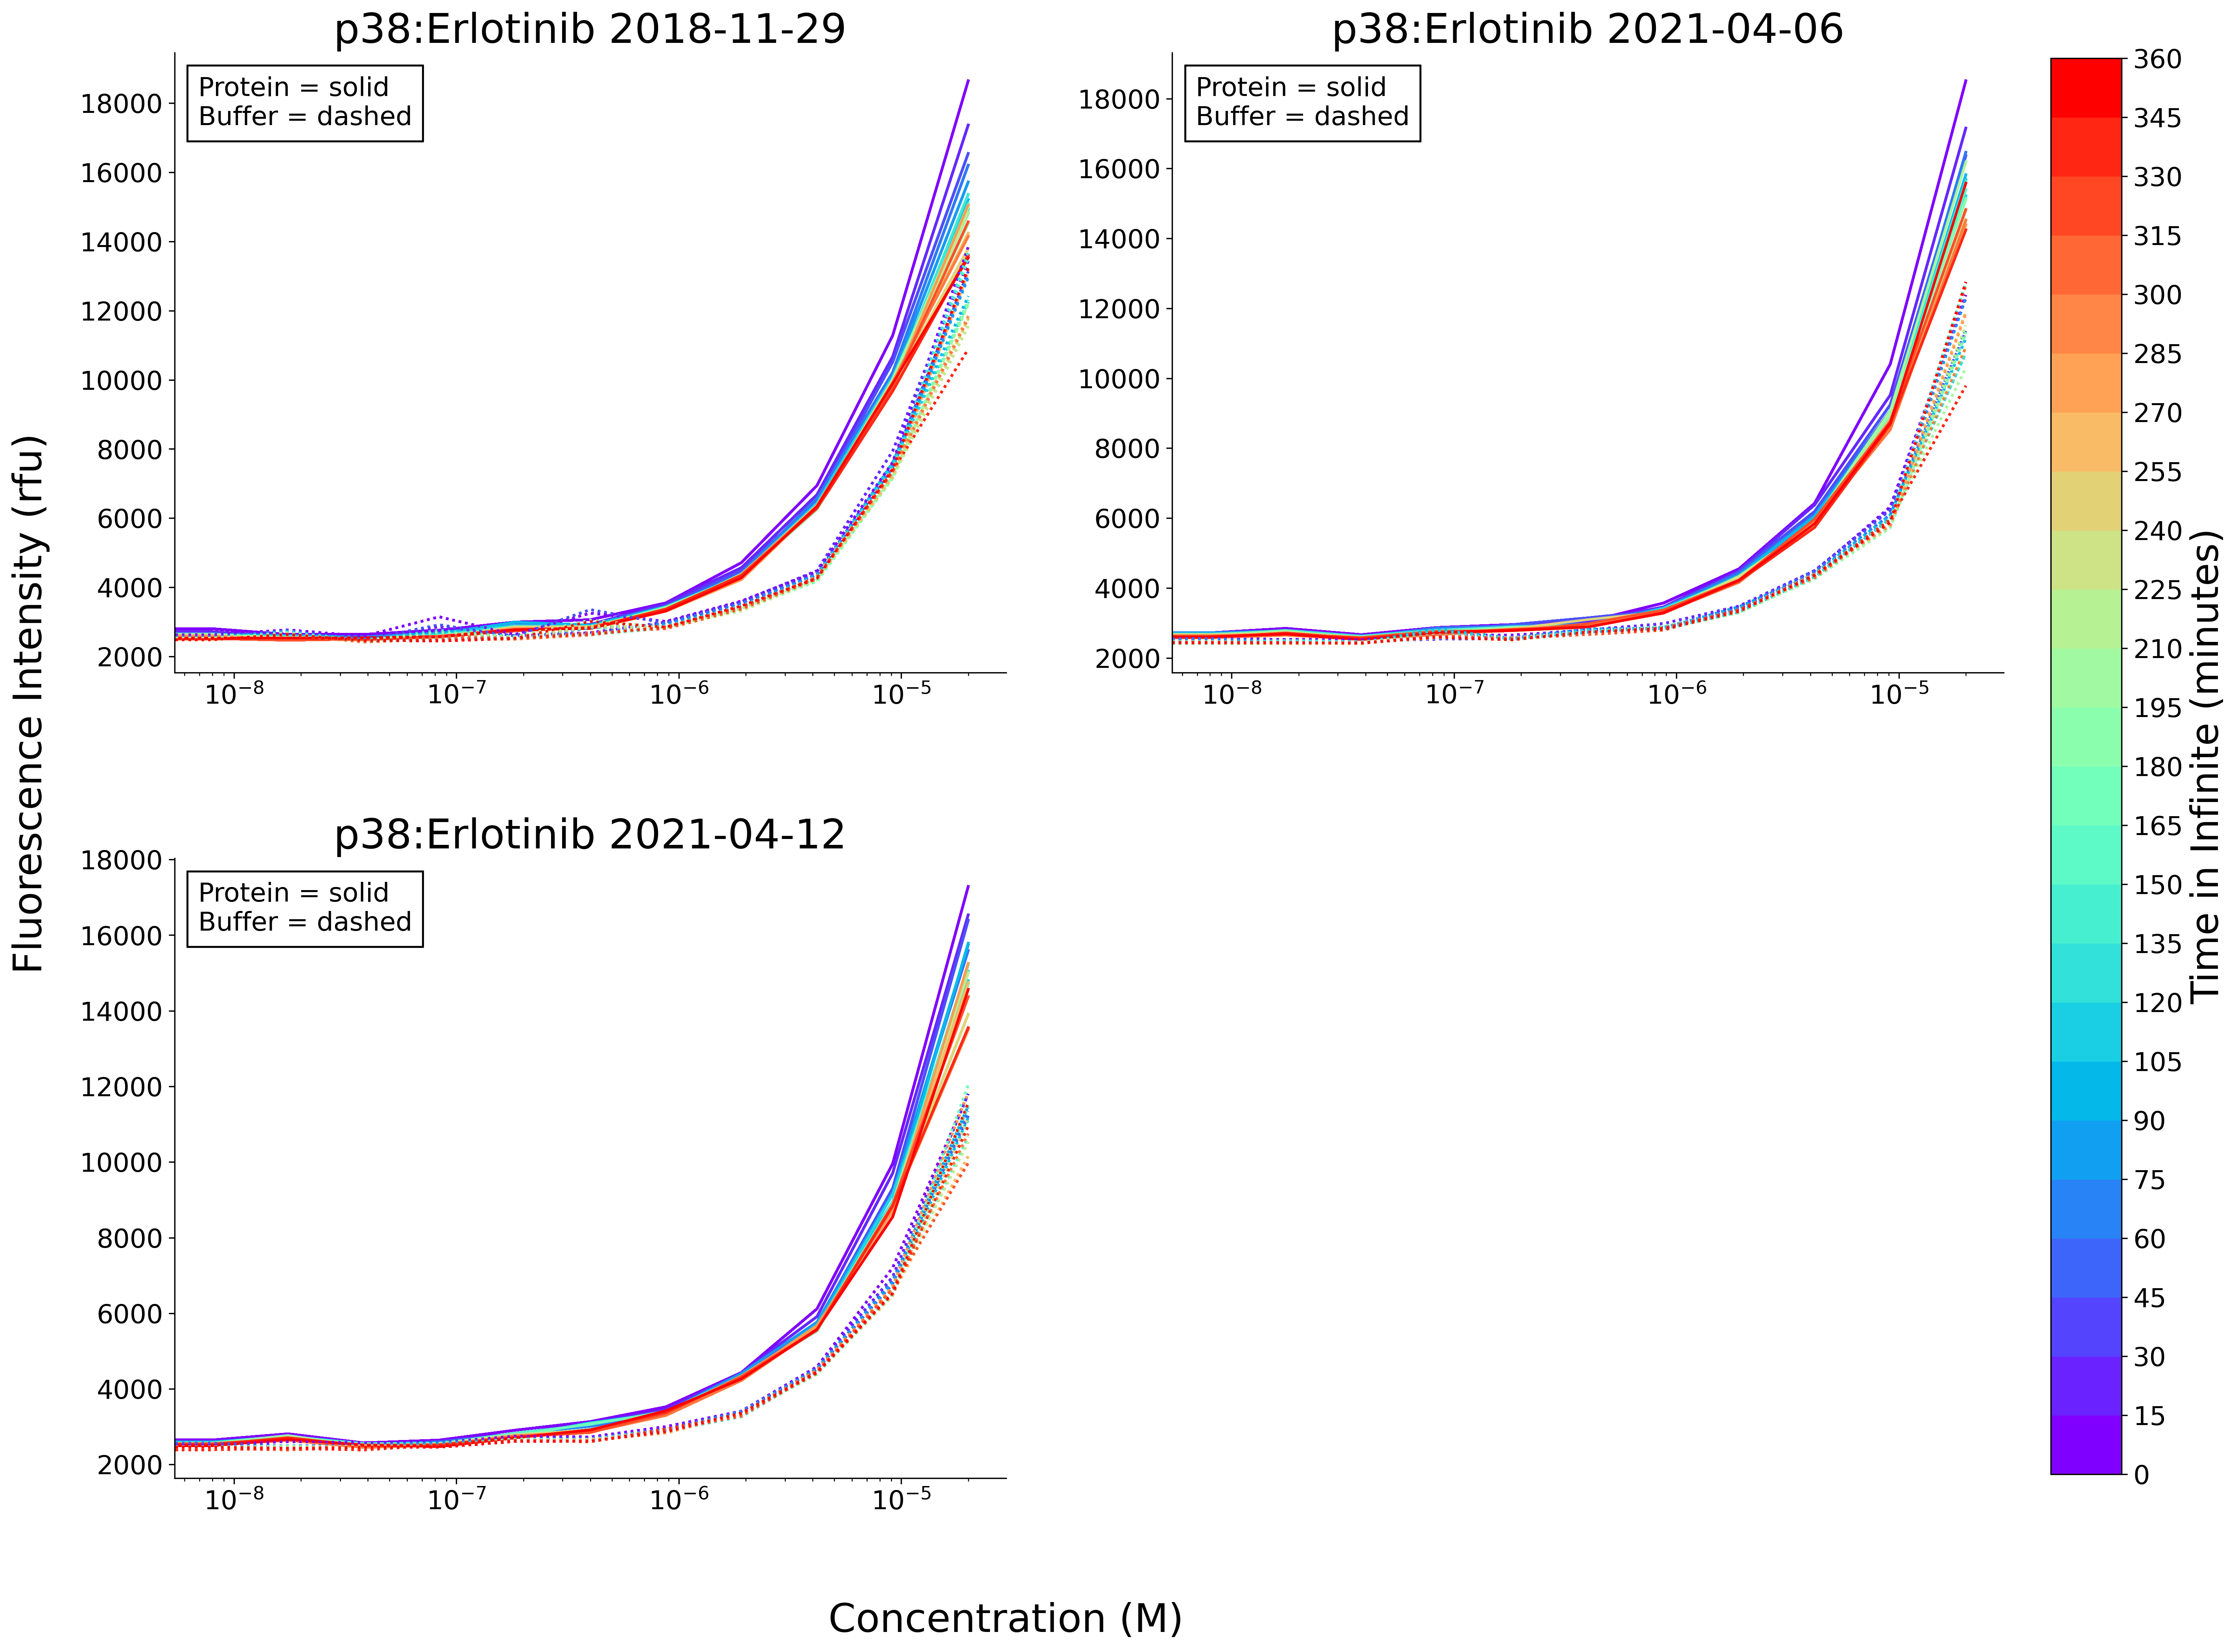

In [48]:
fig = plt.figure(figsize=(20,16), dpi=300)

plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
Abl_bos = fluo_trace_logx(prot='p38', lig='Erlotinib 2018-11-29', y_prot=plotting_data['Erl made 2018-11-29']['complex'], y_buff=plotting_data['Erl made 2018-11-29']['buffer'])

ax1 = fig.add_subplot(2,2,2)
Abl_erl = fluo_trace_logx(prot='p38', lig='Erlotinib 2021-04-06', y_prot=plotting_data['Erl made 2021-04-06']['complex'], y_buff=plotting_data['Erl made 2021-04-06']['buffer'])

ax1 = fig.add_subplot(2,2,3)
Src_bos = fluo_trace_logx(prot='p38', lig='Erlotinib 2021-04-12', y_prot=plotting_data['Erl made 2021-04-12']['complex'], y_buff=plotting_data['Erl made 2021-04-12']['buffer'])

axis = plt.gca()
plt.ylabel('Fluorescence Intensity (rfu)', fontsize=24)
axis.yaxis.set_label_coords(-0.15,1.25)
plt.xlabel('Concentration (M)', fontsize=24)
axis.xaxis.set_label_coords(1,-0.2)

#ax1 = fig.add_subplot(2,2,4)
#Src_erl = fluo_trace_logx(prot='Src WT', lig='Erlotinib', y_prot=plotting_data['Src:ERL']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])


cax = fig.add_axes([.92, 0.127, 0.03, 0.75])

time = [i for i in range(ncycles)] 
time_mins = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
time_wait = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
norm = matplotlib.colors.BoundaryNorm(range(ncycles), cm.rainbow.N)
cmap = plt.get_cmap('rainbow')
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=range(ncycles), boundaries=range(ncycles))
cb.set_label('Time in Infinite (minutes)', fontsize=23)
cb.ax.tick_params(labelsize=16)
cb.ax.set_yticklabels(time_wait)

fig
fig.savefig('20210408_fluo_trace_overtime_logx.pdf', bbox_inches='tight', dpi=300)

## Extract and plot data according to time rather than concentration

In [49]:
# plot fluo values across time with colormap of each concentration 

def fluo_time_plot(prot, lig, y_prot, y_buff):

    for i in range(ncol):
        # create list of timepoints (20 reads that take 5 mins per read, 17 minute wait time after the first 10 reads)
        time = [i for i in range(ncycles)] 
        time_mins = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
        time_wait = [int(data[cycle]['Time_Start']) for cycle in range(ncycles)]
            
        x_values_time = time_wait
        
        color = cm.rainbow(np.linspace(0,1,12))
        for read, c in zip(y_prot.T, color):
            plt.plot(x_values_time, read, c=c, linestyle='solid', linewidth=2)
        for read, c in zip(y_buff.T, color):
            plt.plot(x_values_time, read, c=c, linestyle='dotted', linewidth=2)
        
        ax1.spines['top'].set_visible(False)
        ax1.spines['right'].set_visible(False)

        plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True, labelsize=16)
        plt.tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelsize=16)
        
        plt.title('%s:%s' % (prot, lig), fontsize =25)
        anchored_text = AnchoredText('Protein = solid, Buffer = dashed',  loc='upper right', prop=dict(size=16))
        ax1.add_artist(anchored_text)

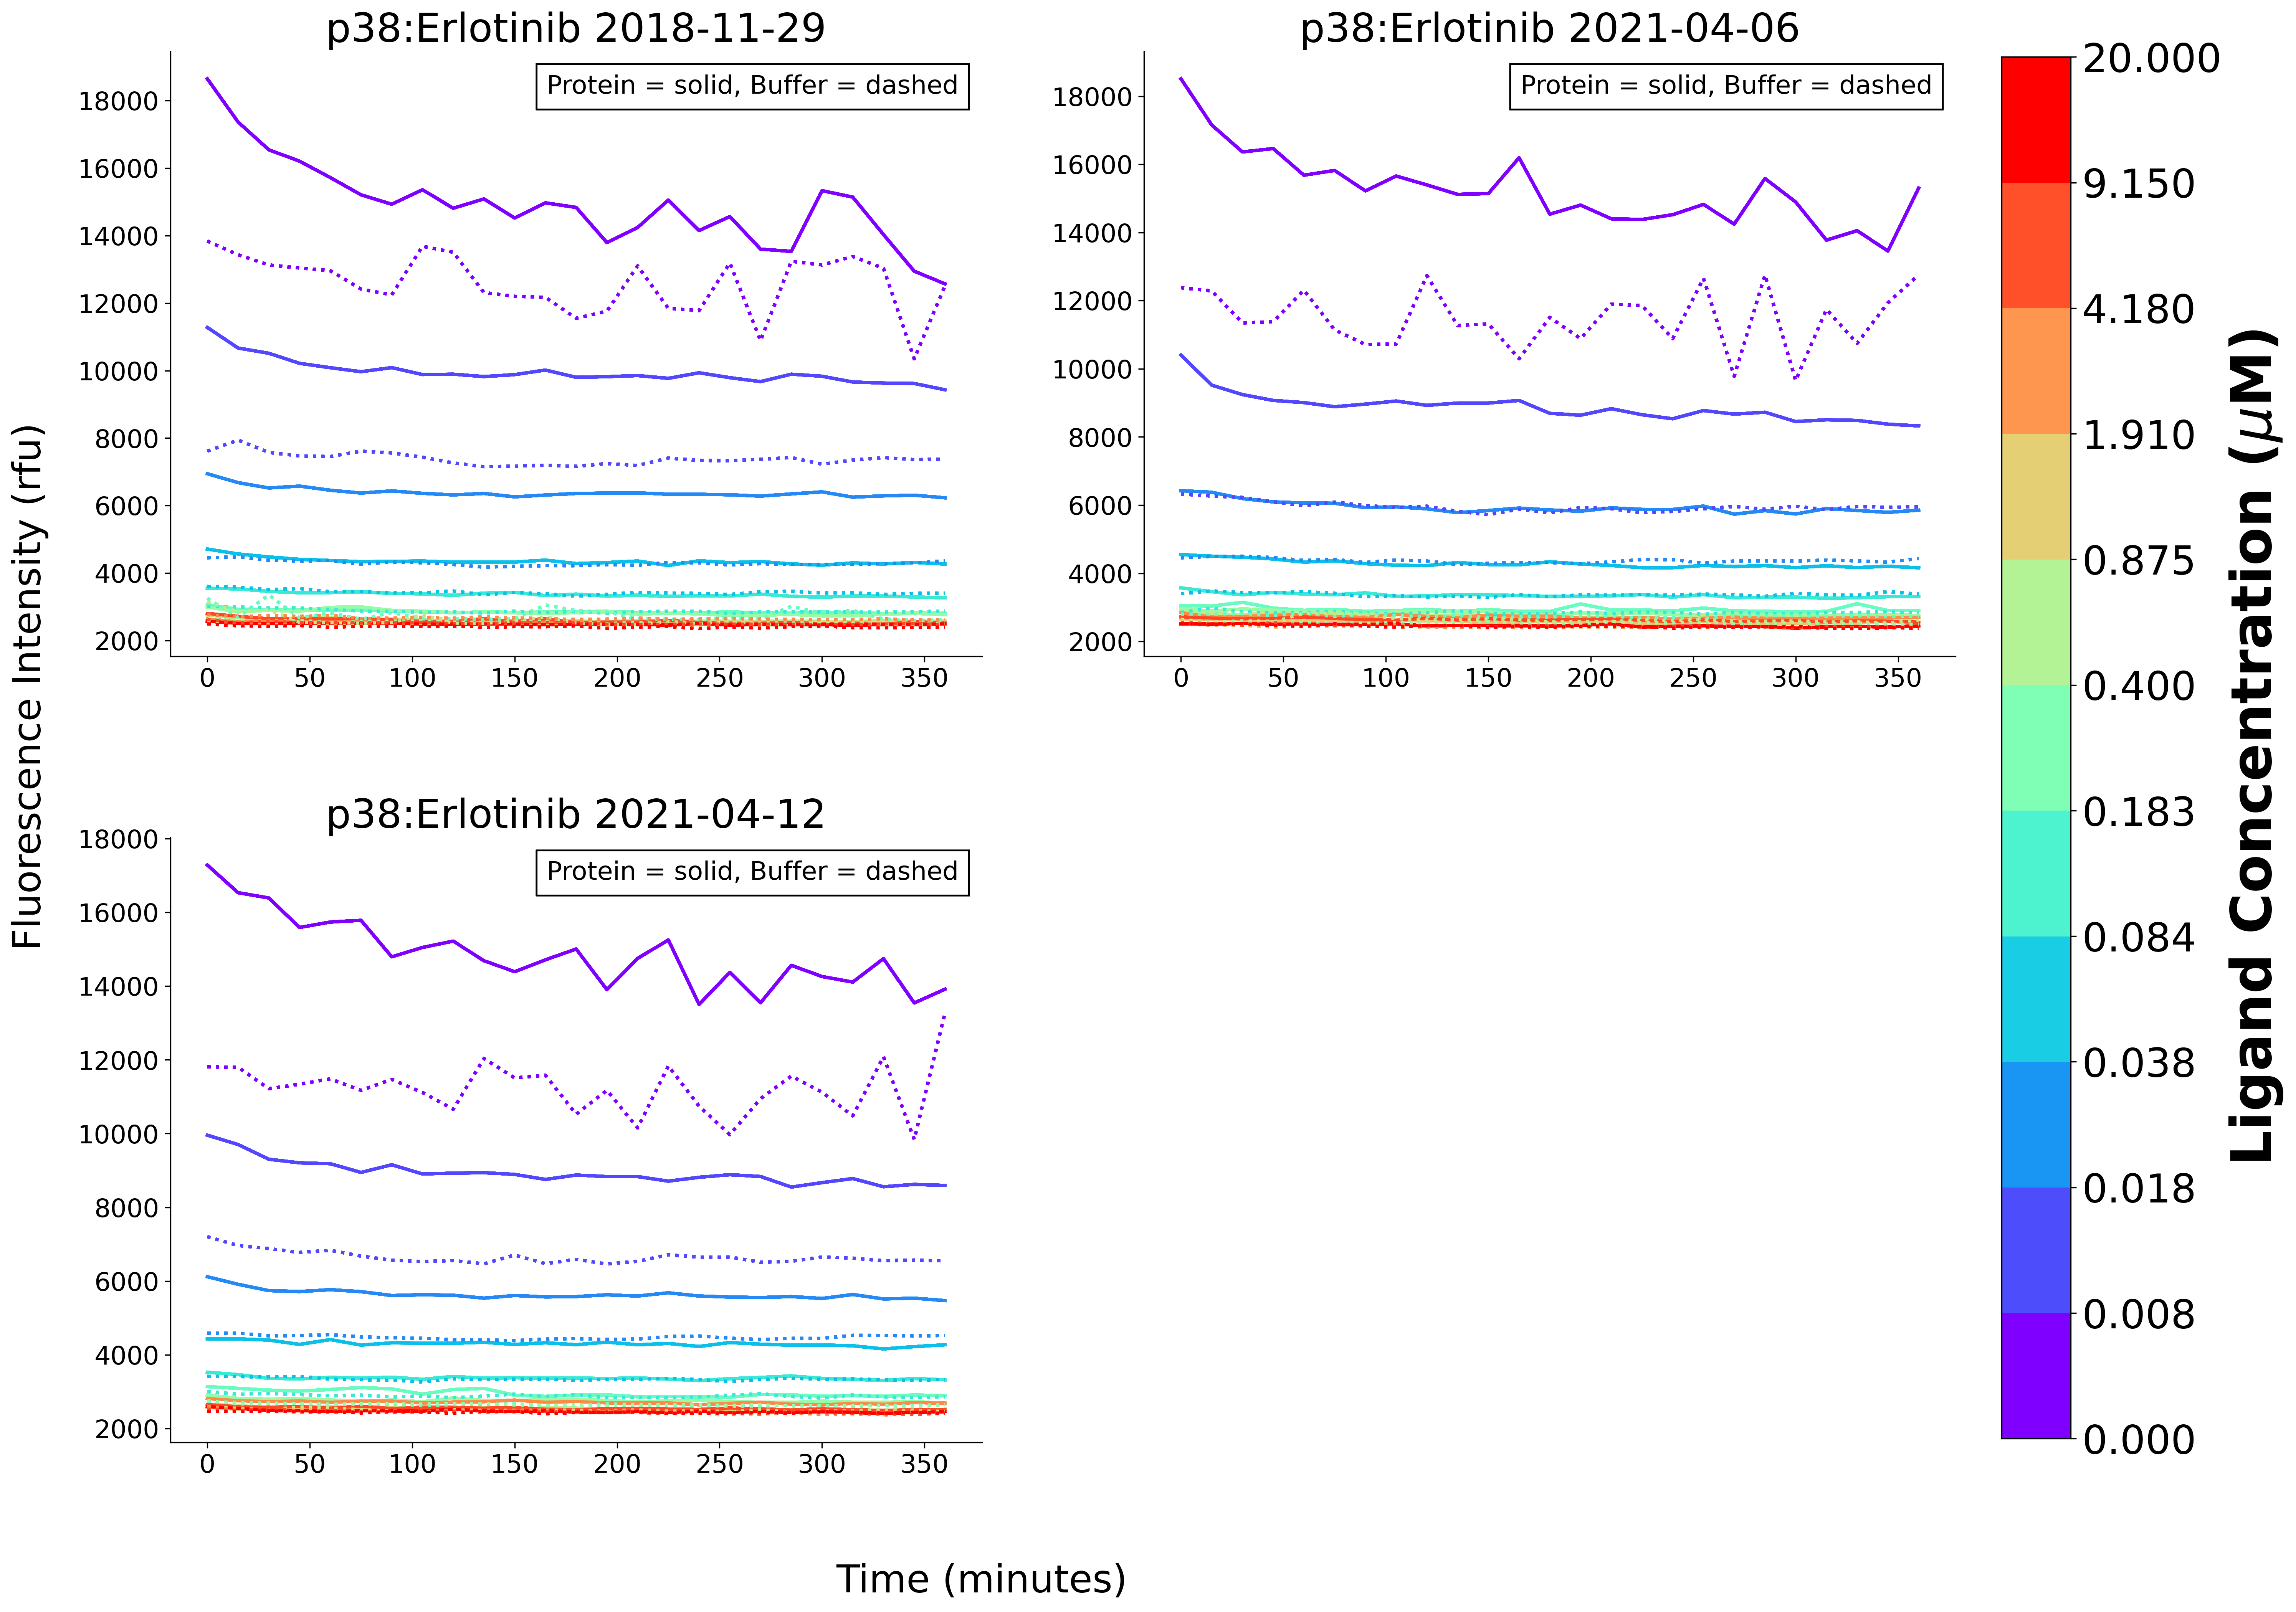

In [52]:
# ncol = 12
nrows=2
ncols=2

fig = plt.figure(figsize=(20,16), dpi=300)

plt.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
Abl_bos = fluo_time_plot(prot='p38', lig='Erlotinib 2018-11-29', y_prot=plotting_data['Erl made 2018-11-29']['complex'], y_buff=plotting_data['Erl made 2018-11-29']['buffer'])

ax1 = fig.add_subplot(2,2,2)
Abl_erl = fluo_time_plot(prot='p38', lig='Erlotinib 2021-04-06', y_prot=plotting_data['Erl made 2021-04-06']['complex'], y_buff=plotting_data['Erl made 2021-04-06']['buffer'])

ax1 = fig.add_subplot(2,2,3)
Src_bos = fluo_time_plot(prot='p38', lig='Erlotinib 2021-04-12', y_prot=plotting_data['Erl made 2021-04-12']['complex'], y_buff=plotting_data['Erl made 2021-04-12']['buffer'])

axis = plt.gca()
plt.ylabel('Fluorescence Intensity (rfu)', fontsize=24)
axis.yaxis.set_label_coords(-0.15,1.25)
plt.xlabel('Time (minutes)', fontsize=24)
axis.xaxis.set_label_coords(1,-0.2)

#ax1 = fig.add_subplot(2,2,4)
#Src_erl = fluo_time_plot(prot='Src WT', lig='Erlotinib', y_prot=plotting_data['Src:ERL']['complex'], y_buff=plotting_data['Abl:BOS']['buffer'])

cax = fig.add_axes([.92, 0.127, 0.03, 0.75])

micro_concentrations = np.multiply(concentrations, 1e6)
norm = matplotlib.colors.BoundaryNorm(micro_concentrations, cm.rainbow.N)
conc_labels = ['{0:.3f}'.format(x) for x in micro_concentrations]
cmap = plt.get_cmap('rainbow')
cb = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=micro_concentrations, boundaries=micro_concentrations)
cb.set_label('Ligand Concentration ($\mu$M)', fontsize=35, fontweight='bold')
cb.ax.tick_params(labelsize=25)
cb.ax.set_yticklabels(conc_labels)

fig
fig.savefig('20210412_well_values_overtime.pdf', bbox_inches='tight', dpi=300)